In [61]:
# Basic
import os
import zipfile
import pandas as pd
import numpy as np

# Visual
import seaborn as sns
from PIL import Image
import cv2
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential,Model
from keras.layers import Flatten,Dense,Dropout

In [62]:
image_dir = "train"

filenames = os.listdir(image_dir)

labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


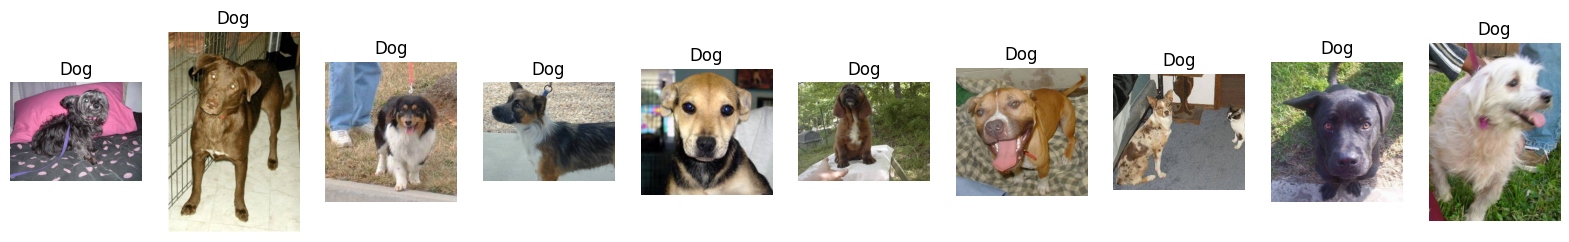

In [63]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):
    
    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

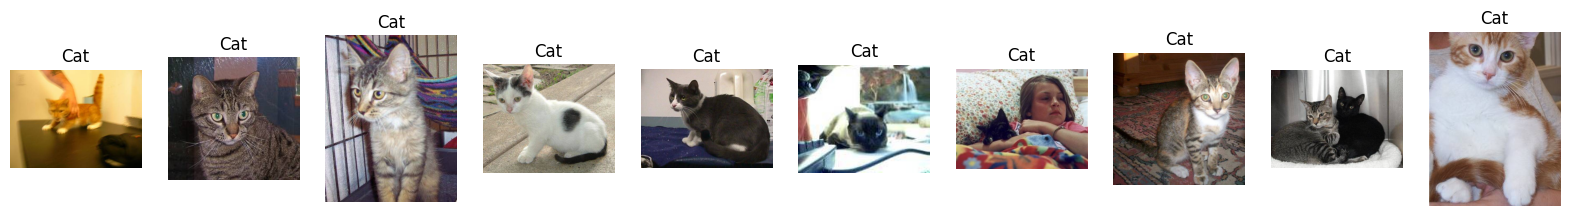

In [64]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):
    
    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

In [65]:
labels = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 23)

label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 23)

In [66]:
batch_size = 64
size = (200, 200)

# Create image data generator
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

train_idg = idg.flow_from_dataframe(X_train, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size)

val_idg = idg.flow_from_dataframe(X_val, "train/", x_col="filename", y_col="label",
                                  batch_size = batch_size,
                                  target_size = size, shuffle = False)

test_idg = idg.flow_from_dataframe(X_test, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size, shuffle = False)

Found 19684 validated image filenames belonging to 2 classes.
Found 2461 validated image filenames belonging to 2 classes.
Found 2460 validated image filenames belonging to 2 classes.


In [67]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(200, 200, 3))

for layer in vgg16_model.layers:
    layer.trainable = False

In [68]:
flat = tf.keras.layers.Flatten() (vgg16_model.output)
dropout1 = tf.keras.layers.Dropout(0.2, name="Dropout1") (flat)
dense1 = tf.keras.layers.Dense(128, activation="relu") (dropout1)
dropout2 = tf.keras.layers.Dropout(0.2, name="Dropout2")(dense1)
output = tf.keras.layers.Dense(2, activation="softmax") (dropout2)

final_model = tf.keras.models.Model(inputs=[vgg16_model.input], outputs=[output])

In [69]:
final_model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics = ["acc"])

In [70]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=2,
                                            factor=0.5, min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss', patience=5,
                              restore_best_weights=True, verbose=0)

In [72]:
history = final_model.fit(train_idg, 
                          batch_size=batch_size, 
                          validation_data=val_idg, 
                          epochs = 5, 
                          callbacks=[learning_rate_reduction,early_stoping])

Epoch 1/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1101s 4s/step - acc: 0.9831 - loss: 0.0494 - val_acc: 0.9793 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 2/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 991s 3s/step - acc: 0.9864 - loss: 0.0399 - val_acc: 0.9781 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 3/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1087s 4s/step - acc: 0.9917 - loss: 0.0260 - val_acc: 0.9797 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 4/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1030s 3s/step - acc: 0.9929 - loss: 0.0196 - val_acc: 0.9813 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 5/5
308/308 ━━━━━━━━━━━━━━━━━━━━ 1019s 3s/step - acc: 0.9935 - loss: 0.0202 - val_acc: 0.9760 - val_loss: 0.1046 - learning_rate: 0.0010


In [77]:
loss3,acc3 = final_model.evaluate(train_idg,batch_size = batch_size, verbose = 0)

print('Accuracy:',acc3*100)

Accuracy: 99.59865808486938


In [74]:
test_dir = "test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create data genenerator for test data
test1_idg =  idg.flow_from_dataframe(test_data, 
                                     "test1/", 
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = batch_size,
                                     target_size=size, 
                                     shuffle = False)

# Test Prediction
test1_predict = final_model.predict(test1_idg)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

Found 12500 validated image filenames belonging to 1 classes.


c:\Users\Felix\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step


,filename,label
0,1.jpg,dog
1,10.jpg,cat
2,100.jpg,cat
3,1000.jpg,dog
4,10000.jpg,dog


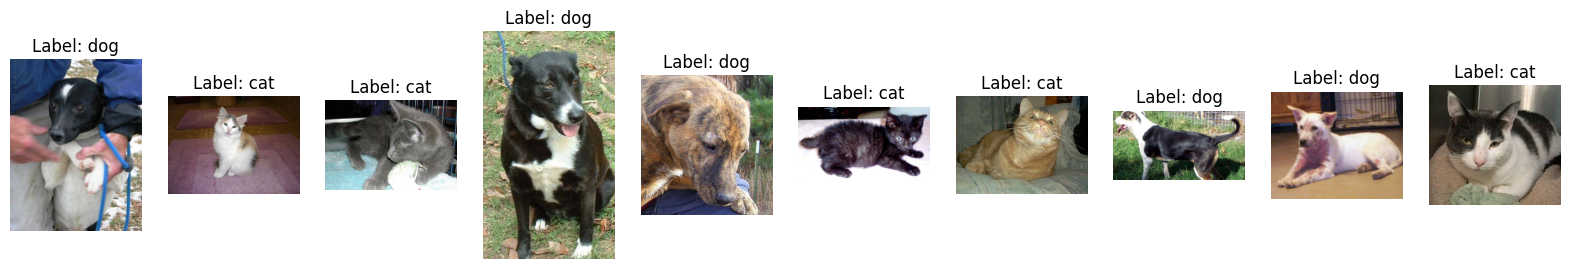

In [75]:
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for idx in range(10):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()

In [76]:
model.save("keras_28x28-128-10_42.keras")